In [1]:
import pandas as pd
import numpy as np
pd.set_option('display.max_rows', None)
# pd.set_option('display.max_columns', None)
# pd.set_option('display.width', None)
# pd.set_option('display.max_colwidth', None)

In [2]:
excel_data_df = pd.ExcelFile(r'../data/egg.xlsx')
excel_data_df = excel_data_df.parse(excel_data_df.sheet_names[0])

In [3]:
result_df = pd.ExcelFile(r'../data/egg-result.xlsx')
result_df = result_df.parse(result_df.sheet_names[0])
result_set = result_df.iloc[:, 1].tolist()

In [4]:
for idx, header in enumerate(excel_data_df.columns.tolist()):
    print(idx, header)

0 Dấu thời gian
1 Địa chỉ email
2 Số báo danh của bạn (Sử dụng SBD đã được gửi qua email)
3 Mục tiêu của bạn khi tham gia vào câu lạc bộ EGG? (Tối thiểu số lựa chọn để tối ưu hóa mục tiêu bạn nhé)
4 Nếu được vào câu lạc bộ và vượt qua các khóa training, tương lai bạn muốn trở thành ai?
5 Tại sao bạn lại chọn nguyện vọng như trên? Bạn có những thế mạnh gì tương ứng nguyện vọng đã chọn. (Câu hỏi này rất quan trọng, hãy thể hiện nhiều nhất có thể nhé)
6 Liệt kê các thành tích nổi bật của em (nếu có)
7 Bạn có thể dành bao nhiêu thời gian cho các hoạt động chung của câu lạc bộ?
8 Bạn có thể dành bao nhiêu thời gian để làm bài tập trong các hoạt động training kiến thức?
9 Bạn có kỹ năng đặc biệt nào khác không?
10 Bạn có mong muốn chia sẻ kiến thức cho cộng đồng không? Đối với các hoạt động được chia sẻ trên fanpage EGG, nếu bạn là một thành viên câu lạc bộ, bạn sẽ cải tiến nó như thế nào để mang lại nhiều giá trị hơn cho cộng đồng IT?


In [5]:
# excel_data_df = excel_data_df[(excel_data_df["11. Bạn mong muốn tham gia vào ban"] == "Nhân sự")]
# excel_data_df = excel_data_df[(excel_data_df["11. Bạn mong muốn tham gia vào ban"] == "Đối ngoại")]
# excel_data_df = excel_data_df[(excel_data_df["11. Bạn mong muốn tham gia vào ban"] == "Chuyên môn")]
excel_data_df.reset_index(drop=True, inplace=True)
excel_data_df.fillna("", inplace = True)
# identity = list(excel_data_df.index.values)
identity = excel_data_df.iloc[:, 1].tolist()

In [6]:
import sys; sys.path.insert(0, '..')
from app.loader import loader
from app.ssmc_fcm import SSMC_FCM

/home/hoangtc125/.local/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


--- Algo Clustering Config:
 {
    "SERVICE_NAME": "ALGO_CLUSTERING",
    "STOPWORD_PATH": "/media/hoangtc125/E/DATN/algo-clustering-service/resources/vn_stopword.txt",
    "FEATURES_PATH": "/media/hoangtc125/E/DATN/algo-clustering-service/resources/features.txt"
}
No GPU available, using the CPU instead.


Some weights of the model checkpoint at vinai/phobert-base were not used when initializing RobertaModel: ['lm_head.decoder.bias', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [7]:
fields_chosen = {
    3: (loader.multilabel_binarizing, 1),
    4: (loader.multilabel_binarizing, 1),
    5: (loader.feature_engineering, 1),
    6: (loader.feature_engineering, 1),
    7: (loader.multilabel_binarizing, 1),
    8: (loader.multilabel_binarizing, 1),
    9: (loader.multilabel_binarizing, 1),
    10: (loader.feature_engineering, 1),
}

In [8]:
from datetime import datetime
vectors = {}
for id_field, config in fields_chosen.items():
    start = datetime.now()
    func = config[0]
    raw_data = excel_data_df.iloc[:, id_field].tolist()
    data = func(raw_data)
    vectors[id_field] = data
    print(f"{round(100 * (list(fields_chosen).index(id_field) + 1) / len(fields_chosen), 2)}% ({datetime.now() - start})")

12.5% (0:00:00.001108)
25.0% (0:00:00.000496)
37.5% (0:00:11.212991)
50.0% (0:00:07.164410)
62.5% (0:00:00.000894)
75.0% (0:00:00.000574)
87.5% (0:00:00.001210)
100.0% (0:00:08.400006)


In [9]:
cluster_fields = [
    # 3,
    # 4,
    # 5,
    6,
    # 7,
    # 8,
    9,
    10,
]
dataset = None
data_field_len = []
data_field_weight = []
for idx, id_field in enumerate(cluster_fields):
    data = np.array(vectors[id_field])
    dataset = data if idx == 0 else np.hstack((dataset, data))
    data_field_len.append(data.shape[1])
    data_field_weight.append(fields_chosen[id_field][1])
dataset.shape, data_field_len, data_field_weight

((158, 1583), [768, 47, 768], [1, 1, 1])

Supervised percentage: 0.0% (0:158)
Cluster members: 
['leducdientin92018@gmail.com', 'thongphil18@gmail.com', 'nguyentuandatk16a@gmail.com', 'nguyentatcuong251204@gmail.com', 'vutienannguyen1210@gmail.com', 'tiennma2k23@cvp.vn', 'vucuong6204nb@gmail.com', 'vietanh142004@gmail.com', 'vuloc34hd@gmail.com', 'gianghoangtruong1111@gmail.com', 'duytan5112@gmail.com', 'huyquangnguyen38@gmail.com', 'haovunguyen2004@gmail.com', 'lamtt262004@gmail.com', 'duchung04st@gmail.com', 'kienkaykths2@gmail.com', 'ngocminh2532003@gmail.con', 'vanvietn824@gmail.com', 'tuanhai1304@gmail.com', 'thangdoi2004@gmail.com', 'viethoanghay123@gmail.com']
['thanh.hh204787@sis.hust.edu.vn', 'bobt3141@gmail.com', 'trinhdung01000100@gmail.com', 'tuannguyen2004zx@gmail.com', 'kq161204@gmail.com', 'nphuochai4@gmail.com', 'lanphuong251064@gmail.com', 'kien2312@gmail.com', 'chientrungha2004@gmail.com', 'thanh.hq225090@sis.hust.edu.vn', 'hoan8e1@gmail.com', 'phamkhactiep159@gmail.com', 'huypham261203@gmail.com', '012030598

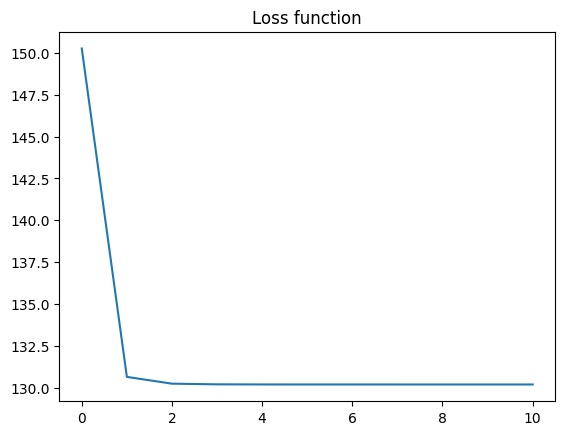

loss functions: 
[150.25527224411337, 130.65082259071295, 130.24591003989588, 130.20587456645515, 130.19936766335857, 130.19809605787296, 130.19781384480203, 130.19774664034355, 130.1977301003007, 130.19772597172772, 130.1977249352234]


In [10]:
supervised_set = [
    [
    
    ]
]
ssmc_fcm = SSMC_FCM(
    dataset=dataset, 
    fields_len=data_field_len,
    fields_weight=[1.2, 1, 1],
    n_clusters=5, 
    identity=identity,
    supervised_set=supervised_set, 
)
ssmc_fcm.clustering()
ssmc_fcm.show_cluster_members()
ssmc_fcm.show_loss_function()

In [11]:
identity_mapping = {iden: idx for idx, iden in enumerate(identity)}
for cluster in ssmc_fcm.pred_labels:
    count = sum([cluster.count(x) for x in result_set])
    print(f"Accuracy: {round(100 * count / len(result_set), 2)}% ({count} in {len(cluster)})")
    # print([identity.index(i) for i in cluster])
    display(excel_data_df.loc[[identity.index(i) for i in cluster]].iloc[:, [1, *cluster_fields]])

Accuracy: 15.0% (6 in 21)


,Địa chỉ email,Liệt kê các thành tích nổi bật của em (nếu có),Bạn có kỹ năng đặc biệt nào khác không?,"Bạn có mong muốn chia sẻ kiến thức cho cộng đồng không? Đối với các hoạt động được chia sẻ trên fanpage EGG, nếu bạn là một thành viên câu lạc bộ, bạn sẽ cải tiến nó như thế nào để mang lại nhiều giá trị hơn cho cộng đồng IT?"
0,leducdientin92018@gmail.com,giải nhất tình tin học\ngiải nhì olympic tin h...,Em chỉ có nhiệt huyết,muốn chia sẻ kiến thức với cộng đồng vì đam mê...
9,thongphil18@gmail.com,giải nhì HSG vật lí tỉnh.,Em chỉ có nhiệt huyết,Em mong muốn được chia sẻ những kiến thức có í...
23,nguyentuandatk16a@gmail.com,Nhì tỉnh tin học cấp tỉnh (C++)\nKhuyến khích ...,Em chỉ có nhiệt huyết,Em có ạ. Em sẽ cùng các anh chị viết bài về ki...
26,nguyentatcuong251204@gmail.com,Giải KK toán cấp thành phố 2021-2022,Em chỉ có nhiệt huyết,Đầu tiên em có thể tương tác và share bài viết...
43,vutienannguyen1210@gmail.com,-Giải Nhì kỳ thi tin học lập trình của trường ...,Em chỉ có nhiệt huyết,- Em sẽ tạo một số video chia sẻ kiến thức như...
44,tiennma2k23@cvp.vn,Là thành viên ĐT của tỉnh dự thi HSG QG môn Ti...,Em chỉ có nhiệt huyết,Dạ em sẽ chia sẻ những thứ mình biết cho các b...
52,vucuong6204nb@gmail.com,Thủ khoa tỉnh Ninh Bình\nTop1% đánh giá tư duy...,Em chỉ có nhiệt huyết,Em có mong muốn được chia sẻ kiến thức trong c...
58,vietanh142004@gmail.com,+Từ lớp 1 đến lớp 9 đều đạt giải các c...,Em chỉ có nhiệt huyết,Em rất vui và tự hào khi được chia sẻ nh...
60,vuloc34hd@gmail.com,Giải Khuyến Khích tỉnh môn Vật Lí 9\nGiải Khuy...,Em chỉ có nhiệt huyết,Em mong muốn chia sẻ những kiến thức hữu ích c...
65,gianghoangtruong1111@gmail.com,Giải khuyến khích kì thi chọn HSG lớp 12 thàn...,Em chỉ có nhiệt huyết,


Accuracy: 20.0% (8 in 80)


,Địa chỉ email,Liệt kê các thành tích nổi bật của em (nếu có),Bạn có kỹ năng đặc biệt nào khác không?,"Bạn có mong muốn chia sẻ kiến thức cho cộng đồng không? Đối với các hoạt động được chia sẻ trên fanpage EGG, nếu bạn là một thành viên câu lạc bộ, bạn sẽ cải tiến nó như thế nào để mang lại nhiều giá trị hơn cho cộng đồng IT?"
1,thanh.hh204787@sis.hust.edu.vn,"CPA (4 kì): 3.9\nĐiểm A: Toán rời rạc, CTDL&GT...",Em chỉ có nhiệt huyết,
2,bobt3141@gmail.com,,Làm trợ giảng,
3,trinhdung01000100@gmail.com,,,
4,tuannguyen2004zx@gmail.com,dạ e chỉ là một người bình thường thui ạ,Em chỉ có nhiệt huyết,dạ e sẽ chia sẻ những kiến thức của e biết dc ...
6,kq161204@gmail.com,,"Tổ chức sự kiện, Em chỉ có nhiệt huyết",Em rất mong muốn có thể đóng góp kiến thức của...
8,nphuochai4@gmail.com,,Em chỉ có nhiệt huyết,Có
10,lanphuong251064@gmail.com,,Em chỉ có nhiệt huyết,Em mong muốn chia sẻ kiến thức trong tầm khả n...
12,kien2312@gmail.com,,"Làm trợ giảng, Sử dụng các công cụ thiết kế ản...",chia sẻ kiến thức là điều đặc biệt mình rất mu...
13,chientrungha2004@gmail.com,,Em chỉ có nhiệt huyết,Em sẽ thường xuyên cập nhật các thông tin quan...
16,thanh.hq225090@sis.hust.edu.vn,Giải ba môn Toán kì thi HSG cấp tỉnh,Em chỉ có nhiệt huyết,


Accuracy: 0.0% (0 in 0)


,Địa chỉ email,Liệt kê các thành tích nổi bật của em (nếu có),Bạn có kỹ năng đặc biệt nào khác không?,"Bạn có mong muốn chia sẻ kiến thức cho cộng đồng không? Đối với các hoạt động được chia sẻ trên fanpage EGG, nếu bạn là một thành viên câu lạc bộ, bạn sẽ cải tiến nó như thế nào để mang lại nhiều giá trị hơn cho cộng đồng IT?"


Accuracy: 0.0% (0 in 0)


,Địa chỉ email,Liệt kê các thành tích nổi bật của em (nếu có),Bạn có kỹ năng đặc biệt nào khác không?,"Bạn có mong muốn chia sẻ kiến thức cho cộng đồng không? Đối với các hoạt động được chia sẻ trên fanpage EGG, nếu bạn là một thành viên câu lạc bộ, bạn sẽ cải tiến nó như thế nào để mang lại nhiều giá trị hơn cho cộng đồng IT?"


Accuracy: 55.0% (22 in 57)


,Địa chỉ email,Liệt kê các thành tích nổi bật của em (nếu có),Bạn có kỹ năng đặc biệt nào khác không?,"Bạn có mong muốn chia sẻ kiến thức cho cộng đồng không? Đối với các hoạt động được chia sẻ trên fanpage EGG, nếu bạn là một thành viên câu lạc bộ, bạn sẽ cải tiến nó như thế nào để mang lại nhiều giá trị hơn cho cộng đồng IT?"
5,dung.work2408@gmail.com,Điểm toiec nội bộ: 760\nThực tập web 6 tháng t...,,Em mong muốn chia sẻ kiến thức cho cộng đồng t...
7,minhhaizdr@gmail.com,Em từng lên ý tưởng cho sự kiện 20/10 hồi lớp ...,"Viết blog IT, Làm trợ giảng, Tổ chức sự kiện","Nếu là một thành viên của câu lạc bộ, em sẽ xi..."
11,thang.dv224899@sis.hust.edu.vn,Giải Khuyến Khích Qgia năm 2021\nGiải ba tỉnh ...,"Làm trợ giảng, Em chỉ có nhiệt huyết",Đầu tiên em sẽ chia sẻ để mọi người biết đến n...
14,nguyenbaolinh1925@hotmail.com,Giải nhất KHKT của huyện và khuyến khích của t...,"Em chỉ có nhiệt huyết, Hiện tại, em chỉ có nhi...","Nếu là tv clb, em sẽ có cách truyền đạt một cá..."
15,huybla166@gmail.com,Đạt giải nhì thành phố môn Vật Lý (lớp 9)\nĐiể...,"Tổ chức sự kiện, Em chỉ có nhiệt huyết",Em có mong muốn chia sẻ kiến thức cho cộng đồn...
17,dvtiendat.work@gmail.com,Giải Khuyến khích HSG Tin cấp Thành phố (TP Hà...,"Tổ chức sự kiện, Em chỉ có nhiệt huyết",Em tin rằng khi mình chia sẻ kiến thức cho ngư...
18,shiraishi2612@gmail.com,-Giải Ba HSGQG môn Vật lý 2021-2022\n-Giải Nhấ...,"Làm trợ giảng, Em chỉ có nhiệt huyết",Mình có thể share về trang cá nhân và các grou...
19,quanghunglion@gmail.com,Thành tích cấp 3:\nGiải Nhất học sinh giỏi Toá...,Làm trợ giảng,Em mong muốn chia sẻ kiến thức cho cộng đồng v...
22,kimduyminh2124@gmail.com,Giải nhì cuộc thi sáng tạo thanh thiếu nhi ( t...,"Sử dụng các công cụ thiết kế ảnh, video,..., E...",Em nghĩ là mình sẽ đăng lên những video về buổ...
24,Tri.HM224461@sis.hust.edu.vn,Em đã đạt 2 giải khuyến khích môn Tin học lập ...,"Viết blog IT, Em chỉ có nhiệt huyết, Em nghĩ n...","Chắc chắn em muốn, nếu làm người trong CLB thì..."
